In [1]:
import tensorflow as tf
import pandas as pd
import ast
!pip install -U nltk
from nltk.tokenize import sent_tokenize, word_tokenize
!pip install -U gensim
import gensim
from gensim.models import Word2Vec
import numpy as np
from sklearn.cluster import SpectralClustering

!pip install -U ipywidgets

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
!pip install -U seaborn
import seaborn as sns
from nltk.data import find

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
import logging
from transformers import logging as hf_logging
from transformers import LongformerModel, LongformerTokenizer

import torch

D0607 00:32:03.017140190      13 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0607 00:32:03.017168240      13 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0607 00:32:03.017171909      13 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0607 00:32:03.017174526      13 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0607 00:32:03.017176880      13 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0607 00:32:03.017179318      13 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0607 00:32:03.017181934      13 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0607 00:32:03.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 KB 35.8 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 KB 4.0 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.2/198.2 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 39.1 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 KB 6.2 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/pyt

In [2]:
full_data = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')

In [3]:
# Data Preprocessing
imp_data = full_data[['id', 'overview', 'title', 'keywords']]

summaries = imp_data['overview'][:360].reset_index(drop=True)
keywords = imp_data['keywords'][:360].reset_index(drop=True)
titles = imp_data['title'][:360].reset_index(drop=True)
ids = imp_data['id'][:360].reset_index(drop=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print(summaries)
# print(keywords.head())

In [4]:
# Get Keyword Embeddings Average for Movies using Word2Vec
import gensim
from gensim.models import Word2Vec
import json
import numpy as np
import nltk
nltk.download('word2vec_sample')

# Parse the JSON and extract the 'name' values
keywords = keywords.apply(lambda x: [keyword['name'] for keyword in json.loads(x)])

# skip-gram on Google News data
from nltk.data import find
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

# Get the Word2Vec embeddings of the keywords and take their mean
keyword_embeddings = []

for keyword_list in keywords:
    embedding_list = []
    for keyword in keyword_list:
        # Check if the word is in the model's vocabulary
        if keyword in word2vec_model:
            embedding = word2vec_model[keyword]
            embedding_list.append(embedding)
    # Take the mean of all keyword embeddings for this movie
    if embedding_list:
        keyword_embedding = np.mean(embedding_list, axis=0)
    else:
        keyword_embedding = np.zeros(300)  # assuming the embeddings are of size 300
    keyword_embeddings.append(keyword_embedding)

keyword_embeddings = np.array(keyword_embeddings)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


In [5]:
# Set TPU strategy
import os
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    print("Running on CPU/GPU")

print("REPLICAS: ", strategy.num_replicas_in_sync)


BATCH_SIZE = 4 * strategy.num_replicas_in_sync

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [6]:
import tensorflow as tf
from transformers import TFLongformerModel, LongformerTokenizer
import numpy as np
import gc
import time
import sys

# Tokenize all the summaries
def longformer_tokenize_data(tokenizer, summaries):
    tokenized_summaries = []
    for summary in summaries:
        # Tokenize the text
        tokenized_summary = tokenizer(summary, truncation=True, max_length=4096, padding='max_length', return_tensors="tf")
        tokenized_summaries.append(tokenized_summary)
    return tokenized_summaries

# Wrap the model call in strategy.scope
with strategy.scope():
    model = TFLongformerModel.from_pretrained('allenai/longformer-base-4096')

# Instantiate the Longformer model and tokenizer
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

# Tokenize summaries with LongformerTokenizer
processed_data = longformer_tokenize_data(tokenizer, summaries)
stop = time.time()

with strategy.scope():
    # Process the data
    summary_embeddings = []
    for i in range(0, len(processed_data), BATCH_SIZE):
        start2 = time.time()
        
        # Create a batch
        batch = processed_data[i:i+BATCH_SIZE]
        batch_input_ids = [item['input_ids'] for item in batch]
        batch_attention_mask = [item['attention_mask'] for item in batch]
        
        # Convert lists to tensors
        batch_input_ids = tf.concat(batch_input_ids, axis=0)
        batch_attention_mask = tf.concat(batch_attention_mask, axis=0)
        
        # Compute embeddings for the batch
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        
        # Reduce sequence length dimension and convert to numpy
        reduced_outputs = tf.reduce_mean(outputs[0], axis=1).numpy()
        summary_embeddings.extend(reduced_outputs)
        
        del batch, batch_input_ids, batch_attention_mask, reduced_outputs
        gc.collect()

        stop2 = time.time()
        print("Time for embedding ", i, ": ", stop2 - start2, " seconds")
        
# # Reshape output embeddings by taking the mean across sequence_length dimension
# # and squeezing to remove batch_size dimension
# embeddings = [np.mean(x, axis=0) for x in summary_embeddings]

# Set print options
np.set_printoptions(threshold=sys.maxsize)

embeddings = np.array(summary_embeddings)

# Memory Cleanup
del summary_embeddings, processed_data
gc.collect()

np.save('/kaggle/working/tmdb_360_summary_and_keyword_embeddings.npy', embeddings)

# Output: NumPy array of vector embeddings
print(embeddings.shape)

Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/longformer-base-4096.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFLongformerModel for predictions without further training.


Time for embedding  0 :  284.8358962535858  seconds
Time for embedding  32 :  286.3524560928345  seconds
Time for embedding  64 :  288.5863764286041  seconds
Time for embedding  96 :  288.75349593162537  seconds
Time for embedding  128 :  291.30858755111694  seconds
Time for embedding  160 :  289.0458085536957  seconds
Time for embedding  192 :  289.2991988658905  seconds
Time for embedding  224 :  291.2506718635559  seconds
Time for embedding  256 :  290.27545714378357  seconds
Time for embedding  288 :  293.33741545677185  seconds
Time for embedding  320 :  294.0516073703766  seconds
Time for embedding  352 :  80.04133701324463  seconds
(360, 768)


In [7]:
# Concatenate the summary embeddings and keyword embeddings
all_embeddings = np.concatenate((embeddings, keyword_embeddings), axis=1)

In [8]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import davies_bouldin_score

number_of_clusters = 120

# Perform spectral clustering
clustering = SpectralClustering(n_clusters=number_of_clusters, assign_labels='discretize', random_state=7).fit(all_embeddings)

# Assign labels to data points
labels = clustering.labels_

# Compute Davies-Bouldin Index
db_score = davies_bouldin_score(all_embeddings, labels)

print('Davies-Bouldin Index: ', db_score)


Davies-Bouldin Index:  1.7631781669650066


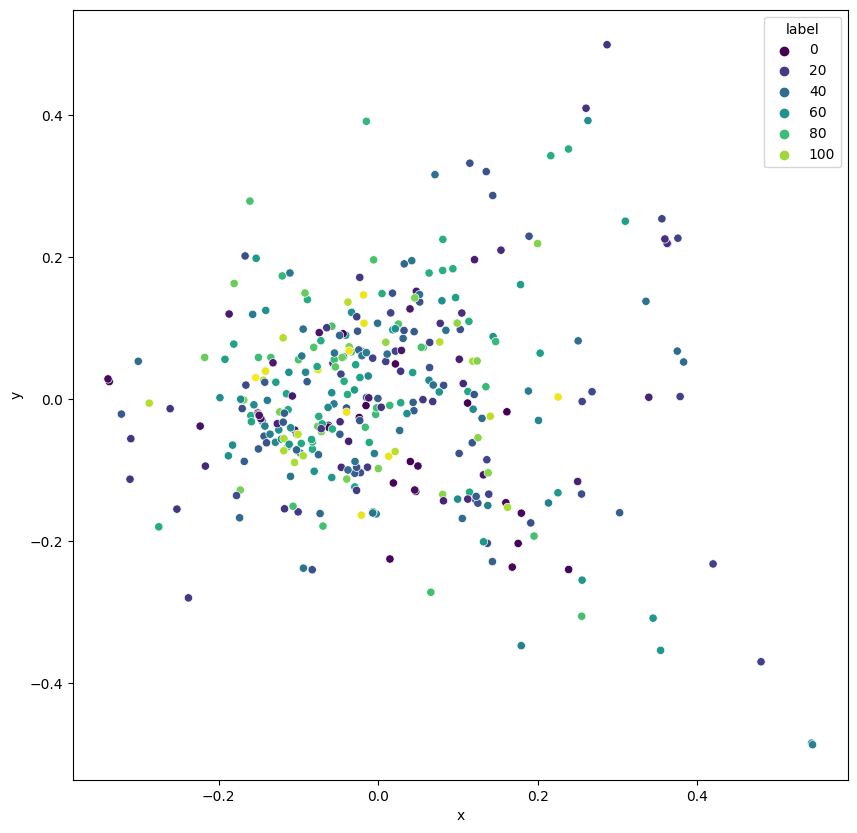

Cluster 0 summaries:
         ID                   Title                                            Summary
87   158852            Tomorrowland  Bound by a shared destiny, a bright, optimisti...
96    27205               Inception  Cobb, a skilled thief who commits corporate es...
123     605  The Matrix Revolutions  The human city of Zion defends itself against ...
125     604     The Matrix Reloaded  Six months after the events depicted in The Ma...
154   81188   Rise of the Guardians  When an evil spirit known as Pitch lays down t...
177   77950                   Turbo  The tale of an ordinary garden snail who dream...


Cluster 1 summaries:
         ID                                Title                                            Summary
85   100402  Captain America: The Winter Soldier  After the cataclysmic events in New York with ...
108   87101                   Terminator Genisys  The year is 2029. John Connor, leader of the r...
127   76341                   Mad Max: Fury Roa

In [9]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the processed_data_array
num_samples, embedding_dim = all_embeddings.shape

reshaped_data_array = all_embeddings.reshape(num_samples, embedding_dim)

# PCA for dimension reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(reshaped_data_array)

# Create a DataFrame for easy plotting
df = pd.DataFrame(reduced_data, columns=['x', 'y'])
df['label'] = clustering.labels_
df['Title'] = titles
df['Summary'] = summaries
df['ID'] = ids

# Plot using seaborn
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='viridis', legend=True)
plt.show()

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50)

# Print out summaries from each cluster
for i in range(number_of_clusters):  # Change this range depending on which clusters you want to look at
    print(f'Cluster {i} summaries:')
    print(df[df['label'] == i][['ID', 'Title', 'Summary']])
    print('\n')

In [10]:
# Get largest cluster size

# cluster_counts = df['label'].value_counts()
# largest_cluster = cluster_counts.idxmax()
# largest_cluster_size = cluster_counts.max()

# print(f"The largest cluster is: {largest_cluster} with size: {largest_cluster_size}")